Example notebook showing how to use the MCMC sampler (currently in development)

In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import emcee

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import MCMCSampler
from nnest.likelihoods import *
from nnest.priors import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Likelihood
#like = Himmelblau(2)
#prior = UniformPrior(2, -5, 5)
like = Rosenbrock(2)
prior = UniformPrior(2, -2, 5)
#like = Gaussian(2, 0.9)
#prior = UniformPrior(2, -5, 5)
#like = Eggbox(2)
#prior = UniformPrior(2, -15, 15)
#like = GaussianShell(2)
#prior = UniformPrior(2, -3, 3)
#like = GaussianMix(2)
#prior = UniformPrior(2, -8, 8)
#like = DoubleGaussianShell(2, centers=[[-4.0, 0.0], [4.0, 0.0]])
#prior = UniformPrior(2, [-7, -3], [7, 3])

In [6]:
sampler = MCMCSampler(like.x_dim, like, hidden_dim=16, num_blocks=3, flow='spline', prior=prior, run_num=1)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

In [7]:
init_samples, loglikes = sampler.init_samples(temperature=1.0, num_chains=20, propose_scale=1.0, steps=100)

[nnest.sampler] [INFO] Acceptance [0.0765] min ESS [1.1525] max ESS [1.1622] average jump [0.0695] min GR [20.2168] max GR [29.7533]


In [8]:
samples = [init_samples[i, :, :].squeeze() for i in range(init_samples.shape[0])]
loglikes = [-loglikes[i, :].squeeze() for i in range(loglikes.shape[0])]

In [9]:
mc = MCSamples(samples=samples, loglikes=loglikes, ignore_rows=0.5)

Removed 0.5 as burn in


In [10]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

15.384173254262489
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1      7.8530853E-01  9.7085630E-01 -8.8916930E-02  1.9747127E+00  two   -1.3289727E+00  2.6475607E+00  two   -1.9333885E+00  3.0764351E+00  two     p_{1}
param2      1.5531732E+00  1.3949258E+00 -1.2378150E-01  2.3703787E+00  two   -4.8225063E-01  4.8105365E+00  two   -6.4311591E-01  5.1733496E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           1.46E-01            0.15            6992
param2           1.13E-01            0.11            9050


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        2.4826  p_{1}
param2        2.8788  p_{2}

var(mean)/mean(var) for eigenvalues of covari

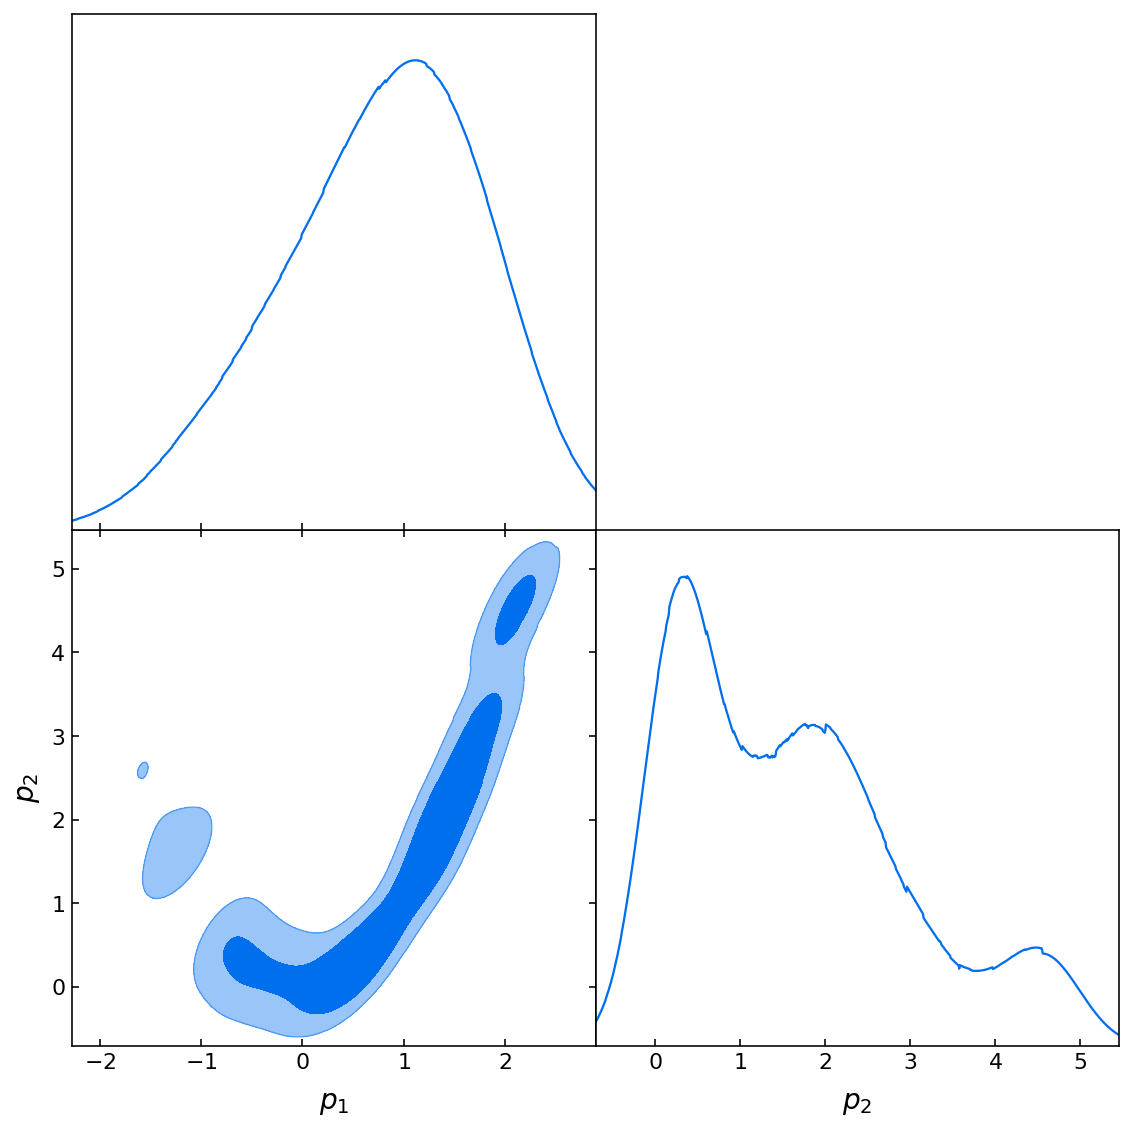

In [11]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

In [12]:
samples = mc.makeSingleSamples(single_thin=10)

In [14]:
sampler.run(init_samples=samples)

[nnest.sampler] [INFO] Alpha [0.7071]


INFO:nnest.sampler:Alpha [0.7071]


[nnest.trainer] [INFO] Number of training samples [104]


INFO:nnest.trainer:Number of training samples [104]


[nnest.trainer] [INFO] Training jitter [0.2000]


INFO:nnest.trainer:Training jitter [0.2000]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0317] validation loss [0.2536]


INFO:nnest.trainer:Epoch [1] train loss [0.0317] validation loss [0.2536]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0287] validation loss [0.2297]


INFO:nnest.trainer:Epoch [50] train loss [0.0287] validation loss [0.2297]


[nnest.trainer] [INFO] Epoch [100] train loss [0.0273] validation loss [0.2129]


INFO:nnest.trainer:Epoch [100] train loss [0.0273] validation loss [0.2129]


[nnest.trainer] [INFO] Epoch [150] train loss [0.0253] validation loss [0.1978]


INFO:nnest.trainer:Epoch [150] train loss [0.0253] validation loss [0.1978]


[nnest.trainer] [INFO] Epoch [200] train loss [0.0246] validation loss [0.1851]


INFO:nnest.trainer:Epoch [200] train loss [0.0246] validation loss [0.1851]


[nnest.trainer] [INFO] Epoch [250] train loss [0.0218] validation loss [0.1706]


INFO:nnest.trainer:Epoch [250] train loss [0.0218] validation loss [0.1706]


[nnest.trainer] [INFO] Epoch [300] train loss [0.0227] validation loss [0.1594]


INFO:nnest.trainer:Epoch [300] train loss [0.0227] validation loss [0.1594]


[nnest.trainer] [INFO] Epoch [350] train loss [0.0219] validation loss [0.1435]


INFO:nnest.trainer:Epoch [350] train loss [0.0219] validation loss [0.1435]


[nnest.trainer] [INFO] Epoch [400] train loss [0.0220] validation loss [0.1363]


INFO:nnest.trainer:Epoch [400] train loss [0.0220] validation loss [0.1363]


[nnest.trainer] [INFO] Epoch [450] train loss [0.0199] validation loss [0.1302]


INFO:nnest.trainer:Epoch [450] train loss [0.0199] validation loss [0.1302]


[nnest.trainer] [INFO] Epoch [500] train loss [0.0194] validation loss [0.1228]


INFO:nnest.trainer:Epoch [500] train loss [0.0194] validation loss [0.1228]


[nnest.trainer] [INFO] Epoch [550] train loss [0.0195] validation loss [0.1187]


INFO:nnest.trainer:Epoch [550] train loss [0.0195] validation loss [0.1187]


[nnest.trainer] [INFO] Epoch [600] train loss [0.0197] validation loss [0.1170]


INFO:nnest.trainer:Epoch [600] train loss [0.0197] validation loss [0.1170]


[nnest.trainer] [INFO] Epoch [648] ran out of patience


INFO:nnest.trainer:Epoch [648] ran out of patience


[nnest.trainer] [INFO] Best epoch [598] validation loss [0.1168]


INFO:nnest.trainer:Best epoch [598] validation loss [0.1168]


[nnest.sampler] [INFO] Step [500] acceptance [0.5012] min ESS [8.6263] max ESS [15.2285] average jump [0.1432] min GR [0.6025] max GR [1.3691]


INFO:nnest.sampler:Step [500] acceptance [0.5012] min ESS [8.6263] max ESS [15.2285] average jump [0.1432] min GR [0.6025] max GR [1.3691]


[nnest.sampler] [INFO] Bootstrap step [2], ncalls [2806], nsamples [251] scale [0.3244]


INFO:nnest.sampler:Bootstrap step [2], ncalls [2806], nsamples [251] scale [0.3244]


[nnest.trainer] [INFO] Number of training samples [355]


INFO:nnest.trainer:Number of training samples [355]


[nnest.trainer] [INFO] Training jitter [0.1525]


INFO:nnest.trainer:Training jitter [0.1525]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0231] validation loss [0.0438]


INFO:nnest.trainer:Epoch [1] train loss [0.0231] validation loss [0.0438]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0178] validation loss [0.0274]


INFO:nnest.trainer:Epoch [50] train loss [0.0178] validation loss [0.0274]


[nnest.trainer] [INFO] Epoch [100] train loss [0.0182] validation loss [0.0257]


INFO:nnest.trainer:Epoch [100] train loss [0.0182] validation loss [0.0257]


[nnest.trainer] [INFO] Epoch [150] train loss [0.0175] validation loss [0.0268]


INFO:nnest.trainer:Epoch [150] train loss [0.0175] validation loss [0.0268]


[nnest.trainer] [INFO] Epoch [150] ran out of patience


INFO:nnest.trainer:Epoch [150] ran out of patience


[nnest.trainer] [INFO] Best epoch [100] validation loss [0.0257]


INFO:nnest.trainer:Best epoch [100] validation loss [0.0257]


[nnest.sampler] [INFO] Step [500] acceptance [0.5216] min ESS [6.0349] max ESS [9.9912] average jump [0.1929] min GR [1.4024] max GR [3.2189]


INFO:nnest.sampler:Step [500] acceptance [0.5216] min ESS [6.0349] max ESS [9.9912] average jump [0.1929] min GR [1.4024] max GR [3.2189]


[nnest.sampler] [INFO] Bootstrap step [3], ncalls [5515], nsamples [251] scale [0.4814]


INFO:nnest.sampler:Bootstrap step [3], ncalls [5515], nsamples [251] scale [0.4814]


[nnest.trainer] [INFO] Number of training samples [606]


INFO:nnest.trainer:Number of training samples [606]


[nnest.trainer] [INFO] Training jitter [0.1050]


INFO:nnest.trainer:Training jitter [0.1050]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0134] validation loss [0.0148]


INFO:nnest.trainer:Epoch [1] train loss [0.0134] validation loss [0.0148]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0123] validation loss [0.0103]


INFO:nnest.trainer:Epoch [50] train loss [0.0123] validation loss [0.0103]


[nnest.trainer] [INFO] Epoch [82] ran out of patience


INFO:nnest.trainer:Epoch [82] ran out of patience


[nnest.trainer] [INFO] Best epoch [32] validation loss [0.0094]


INFO:nnest.trainer:Best epoch [32] validation loss [0.0094]


[nnest.sampler] [INFO] Step [500] acceptance [0.5208] min ESS [5.8207] max ESS [7.8757] average jump [0.2169] min GR [1.5376] max GR [2.9385]


INFO:nnest.sampler:Step [500] acceptance [0.5208] min ESS [5.8207] max ESS [7.8757] average jump [0.2169] min GR [1.5376] max GR [2.9385]


[nnest.sampler] [INFO] Bootstrap step [4], ncalls [8163], nsamples [251] scale [0.5591]


INFO:nnest.sampler:Bootstrap step [4], ncalls [8163], nsamples [251] scale [0.5591]


[nnest.trainer] [INFO] Number of training samples [857]


INFO:nnest.trainer:Number of training samples [857]


[nnest.trainer] [INFO] Training jitter [0.0575]


INFO:nnest.trainer:Training jitter [0.0575]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0090] validation loss [0.0084]


INFO:nnest.trainer:Epoch [1] train loss [0.0090] validation loss [0.0084]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0065] validation loss [0.0036]


INFO:nnest.trainer:Epoch [50] train loss [0.0065] validation loss [0.0036]


[nnest.trainer] [INFO] Epoch [100] train loss [0.0062] validation loss [0.0037]


INFO:nnest.trainer:Epoch [100] train loss [0.0062] validation loss [0.0037]


[nnest.trainer] [INFO] Epoch [150] train loss [0.0064] validation loss [0.0036]


INFO:nnest.trainer:Epoch [150] train loss [0.0064] validation loss [0.0036]


[nnest.trainer] [INFO] Epoch [158] ran out of patience


INFO:nnest.trainer:Epoch [158] ran out of patience


[nnest.trainer] [INFO] Best epoch [108] validation loss [0.0033]


INFO:nnest.trainer:Best epoch [108] validation loss [0.0033]


[nnest.sampler] [INFO] Step [500] acceptance [0.5260] min ESS [7.9757] max ESS [17.2062] average jump [0.2809] min GR [1.0986] max GR [2.9560]


INFO:nnest.sampler:Step [500] acceptance [0.5260] min ESS [7.9757] max ESS [17.2062] average jump [0.2809] min GR [1.0986] max GR [2.9560]


[nnest.sampler] [INFO] Bootstrap step [5], ncalls [10688], nsamples [251] scale [1.0703]


INFO:nnest.sampler:Bootstrap step [5], ncalls [10688], nsamples [251] scale [1.0703]


[nnest.trainer] [INFO] Number of training samples [1108]


INFO:nnest.trainer:Number of training samples [1108]


[nnest.trainer] [INFO] Training jitter [0.0100]


INFO:nnest.trainer:Training jitter [0.0100]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0022] validation loss [0.0023]


INFO:nnest.trainer:Epoch [1] train loss [0.0022] validation loss [0.0023]


[nnest.trainer] [INFO] Epoch [50] train loss [-0.0002] validation loss [0.0007]


INFO:nnest.trainer:Epoch [50] train loss [-0.0002] validation loss [0.0007]


[nnest.trainer] [INFO] Epoch [68] ran out of patience


INFO:nnest.trainer:Epoch [68] ran out of patience


[nnest.trainer] [INFO] Best epoch [18] validation loss [0.0005]


INFO:nnest.trainer:Best epoch [18] validation loss [0.0005]


[nnest.trainer] [INFO] Number of training samples [1108]


INFO:nnest.trainer:Number of training samples [1108]


[nnest.trainer] [INFO] Training jitter [0.0100]


INFO:nnest.trainer:Training jitter [0.0100]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0000] validation loss [-0.0003]


INFO:nnest.trainer:Epoch [1] train loss [0.0000] validation loss [-0.0003]


[nnest.trainer] [INFO] Epoch [50] train loss [-0.0003] validation loss [-0.0005]


INFO:nnest.trainer:Epoch [50] train loss [-0.0003] validation loss [-0.0005]


[nnest.trainer] [INFO] Epoch [73] ran out of patience


INFO:nnest.trainer:Epoch [73] ran out of patience


[nnest.trainer] [INFO] Best epoch [23] validation loss [-0.0006]


INFO:nnest.trainer:Best epoch [23] validation loss [-0.0006]


[nnest.sampler] [INFO] Step [200] acceptance [0.5420] min ESS [8.0783] max ESS [15.2692] average jump [0.3694] min GR [0.1380] max GR [0.4900]


INFO:nnest.sampler:Step [200] acceptance [0.5420] min ESS [8.0783] max ESS [15.2692] average jump [0.3694] min GR [0.1380] max GR [0.4900]


[nnest.sampler] [INFO] Step [400] acceptance [0.5375] min ESS [12.5859] max ESS [24.4096] average jump [0.3607] min GR [0.5084] max GR [1.4282]


INFO:nnest.sampler:Step [400] acceptance [0.5375] min ESS [12.5859] max ESS [24.4096] average jump [0.3607] min GR [0.5084] max GR [1.4282]


[nnest.sampler] [INFO] Step [600] acceptance [0.5537] min ESS [22.3283] max ESS [40.7553] average jump [0.3990] min GR [0.5122] max GR [1.4213]


INFO:nnest.sampler:Step [600] acceptance [0.5537] min ESS [22.3283] max ESS [40.7553] average jump [0.3990] min GR [0.5122] max GR [1.4213]


[nnest.sampler] [INFO] Step [800] acceptance [0.5610] min ESS [34.0876] max ESS [62.4929] average jump [0.4004] min GR [0.3830] max GR [1.1389]


INFO:nnest.sampler:Step [800] acceptance [0.5610] min ESS [34.0876] max ESS [62.4929] average jump [0.4004] min GR [0.3830] max GR [1.1389]


[nnest.sampler] [INFO] Step [1000] acceptance [0.5542] min ESS [41.6140] max ESS [70.6651] average jump [0.3987] min GR [0.3976] max GR [1.1288]


INFO:nnest.sampler:Step [1000] acceptance [0.5542] min ESS [41.6140] max ESS [70.6651] average jump [0.3987] min GR [0.3976] max GR [1.1288]


[nnest.sampler] [INFO] Step [1200] acceptance [0.5608] min ESS [48.9934] max ESS [82.9381] average jump [0.3948] min GR [0.1829] max GR [0.5759]


INFO:nnest.sampler:Step [1200] acceptance [0.5608] min ESS [48.9934] max ESS [82.9381] average jump [0.3948] min GR [0.1829] max GR [0.5759]


[nnest.sampler] [INFO] Step [1400] acceptance [0.5587] min ESS [56.7527] max ESS [98.0756] average jump [0.3991] min GR [0.2318] max GR [0.7300]


INFO:nnest.sampler:Step [1400] acceptance [0.5587] min ESS [56.7527] max ESS [98.0756] average jump [0.3991] min GR [0.2318] max GR [0.7300]


[nnest.sampler] [INFO] Step [1600] acceptance [0.5567] min ESS [68.6657] max ESS [115.4736] average jump [0.3984] min GR [0.2927] max GR [0.8763]


INFO:nnest.sampler:Step [1600] acceptance [0.5567] min ESS [68.6657] max ESS [115.4736] average jump [0.3984] min GR [0.2927] max GR [0.8763]


[nnest.sampler] [INFO] Step [1800] acceptance [0.5540] min ESS [81.5552] max ESS [134.2137] average jump [0.3973] min GR [0.2232] max GR [0.6939]


INFO:nnest.sampler:Step [1800] acceptance [0.5540] min ESS [81.5552] max ESS [134.2137] average jump [0.3973] min GR [0.2232] max GR [0.6939]


[nnest.sampler] [INFO] Step [2000] acceptance [0.5564] min ESS [90.7135] max ESS [151.9827] average jump [0.3984] min GR [0.1458] max GR [0.4783]


INFO:nnest.sampler:Step [2000] acceptance [0.5564] min ESS [90.7135] max ESS [151.9827] average jump [0.3984] min GR [0.1458] max GR [0.4783]


[nnest.sampler] [INFO] Step [2200] acceptance [0.5564] min ESS [98.9770] max ESS [169.4493] average jump [0.3947] min GR [0.2091] max GR [0.6612]


INFO:nnest.sampler:Step [2200] acceptance [0.5564] min ESS [98.9770] max ESS [169.4493] average jump [0.3947] min GR [0.2091] max GR [0.6612]


[nnest.sampler] [INFO] Step [2400] acceptance [0.5535] min ESS [109.3331] max ESS [188.8804] average jump [0.3940] min GR [0.1900] max GR [0.6023]


INFO:nnest.sampler:Step [2400] acceptance [0.5535] min ESS [109.3331] max ESS [188.8804] average jump [0.3940] min GR [0.1900] max GR [0.6023]


[nnest.sampler] [INFO] Step [2600] acceptance [0.5542] min ESS [122.9606] max ESS [208.1182] average jump [0.3976] min GR [0.1834] max GR [0.5765]


INFO:nnest.sampler:Step [2600] acceptance [0.5542] min ESS [122.9606] max ESS [208.1182] average jump [0.3976] min GR [0.1834] max GR [0.5765]


[nnest.sampler] [INFO] Step [2800] acceptance [0.5540] min ESS [135.6737] max ESS [230.0871] average jump [0.3970] min GR [0.1976] max GR [0.6144]


INFO:nnest.sampler:Step [2800] acceptance [0.5540] min ESS [135.6737] max ESS [230.0871] average jump [0.3970] min GR [0.1976] max GR [0.6144]


[nnest.sampler] [INFO] Step [3000] acceptance [0.5529] min ESS [148.6304] max ESS [249.1888] average jump [0.3967] min GR [0.1920] max GR [0.5982]


INFO:nnest.sampler:Step [3000] acceptance [0.5529] min ESS [148.6304] max ESS [249.1888] average jump [0.3967] min GR [0.1920] max GR [0.5982]


[nnest.sampler] [INFO] Step [3200] acceptance [0.5531] min ESS [161.8434] max ESS [269.7515] average jump [0.3970] min GR [0.1757] max GR [0.5493]


INFO:nnest.sampler:Step [3200] acceptance [0.5531] min ESS [161.8434] max ESS [269.7515] average jump [0.3970] min GR [0.1757] max GR [0.5493]


[nnest.sampler] [INFO] Step [3400] acceptance [0.5525] min ESS [174.0288] max ESS [288.8642] average jump [0.3974] min GR [0.1395] max GR [0.4448]


INFO:nnest.sampler:Step [3400] acceptance [0.5525] min ESS [174.0288] max ESS [288.8642] average jump [0.3974] min GR [0.1395] max GR [0.4448]


[nnest.sampler] [INFO] Step [3600] acceptance [0.5538] min ESS [183.6069] max ESS [304.5832] average jump [0.3976] min GR [0.1024] max GR [0.3350]


INFO:nnest.sampler:Step [3600] acceptance [0.5538] min ESS [183.6069] max ESS [304.5832] average jump [0.3976] min GR [0.1024] max GR [0.3350]


[nnest.sampler] [INFO] Step [3800] acceptance [0.5537] min ESS [192.6661] max ESS [314.9272] average jump [0.3980] min GR [0.1166] max GR [0.3722]


INFO:nnest.sampler:Step [3800] acceptance [0.5537] min ESS [192.6661] max ESS [314.9272] average jump [0.3980] min GR [0.1166] max GR [0.3722]


[nnest.sampler] [INFO] Step [4000] acceptance [0.5546] min ESS [203.1113] max ESS [333.4525] average jump [0.3999] min GR [0.1271] max GR [0.4024]


INFO:nnest.sampler:Step [4000] acceptance [0.5546] min ESS [203.1113] max ESS [333.4525] average jump [0.3999] min GR [0.1271] max GR [0.4024]


[nnest.sampler] [INFO] Step [4200] acceptance [0.5546] min ESS [213.8689] max ESS [349.9334] average jump [0.4000] min GR [0.0854] max GR [0.2791]


INFO:nnest.sampler:Step [4200] acceptance [0.5546] min ESS [213.8689] max ESS [349.9334] average jump [0.4000] min GR [0.0854] max GR [0.2791]


[nnest.sampler] [INFO] Step [4400] acceptance [0.5560] min ESS [224.9349] max ESS [368.1487] average jump [0.3998] min GR [0.0896] max GR [0.2924]


INFO:nnest.sampler:Step [4400] acceptance [0.5560] min ESS [224.9349] max ESS [368.1487] average jump [0.3998] min GR [0.0896] max GR [0.2924]


[nnest.sampler] [INFO] Step [4600] acceptance [0.5543] min ESS [232.6490] max ESS [380.5914] average jump [0.3986] min GR [0.0859] max GR [0.2791]


INFO:nnest.sampler:Step [4600] acceptance [0.5543] min ESS [232.6490] max ESS [380.5914] average jump [0.3986] min GR [0.0859] max GR [0.2791]


[nnest.sampler] [INFO] Step [4800] acceptance [0.5550] min ESS [247.2586] max ESS [400.7832] average jump [0.3995] min GR [0.0781] max GR [0.2530]


INFO:nnest.sampler:Step [4800] acceptance [0.5550] min ESS [247.2586] max ESS [400.7832] average jump [0.3995] min GR [0.0781] max GR [0.2530]


[nnest.sampler] [INFO] Step [5000] acceptance [0.5542] min ESS [261.7904] max ESS [421.3080] average jump [0.3985] min GR [0.0633] max GR [0.2062]


INFO:nnest.sampler:Step [5000] acceptance [0.5542] min ESS [261.7904] max ESS [421.3080] average jump [0.3985] min GR [0.0633] max GR [0.2062]


ncall: 31186



In [15]:
like.num_evaluations

33231

In [16]:
samples = [sampler.samples[i, :, :].squeeze() for i in range(sampler.samples.shape[0])]
latent_samples = [sampler.latent_samples[i, :, :].squeeze() for i in range(sampler.latent_samples.shape[0])]
loglikes = [sampler.loglikes[i, :].squeeze() for i in range(sampler.loglikes.shape[0])]

In [17]:
mc = MCSamples(samples=samples, loglikes=loglikes)

Removed no burn in


In [18]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

1496.1037096024284
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1      8.8462519E-01  7.0554334E-01  1.1733606E-01  1.6516041E+00  two   -3.6108991E-01  2.1677539E+00  two   -7.7455923E-01  2.3803354E+00  two     p_{1}
param2      1.2761998E+00  1.3159356E+00 -1.2239500E-01  1.6796434E+00  two   -1.6018139E-01  4.7284249E+00  two   -1.6545518E-01  4.8279030E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           1.65E+01           16.54            1512
param2           1.45E+01           14.45            1730


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        0.0605  p_{1}
param2        0.0636  p_{2}

var(mean)/mean(var) for eigenvalues of covari

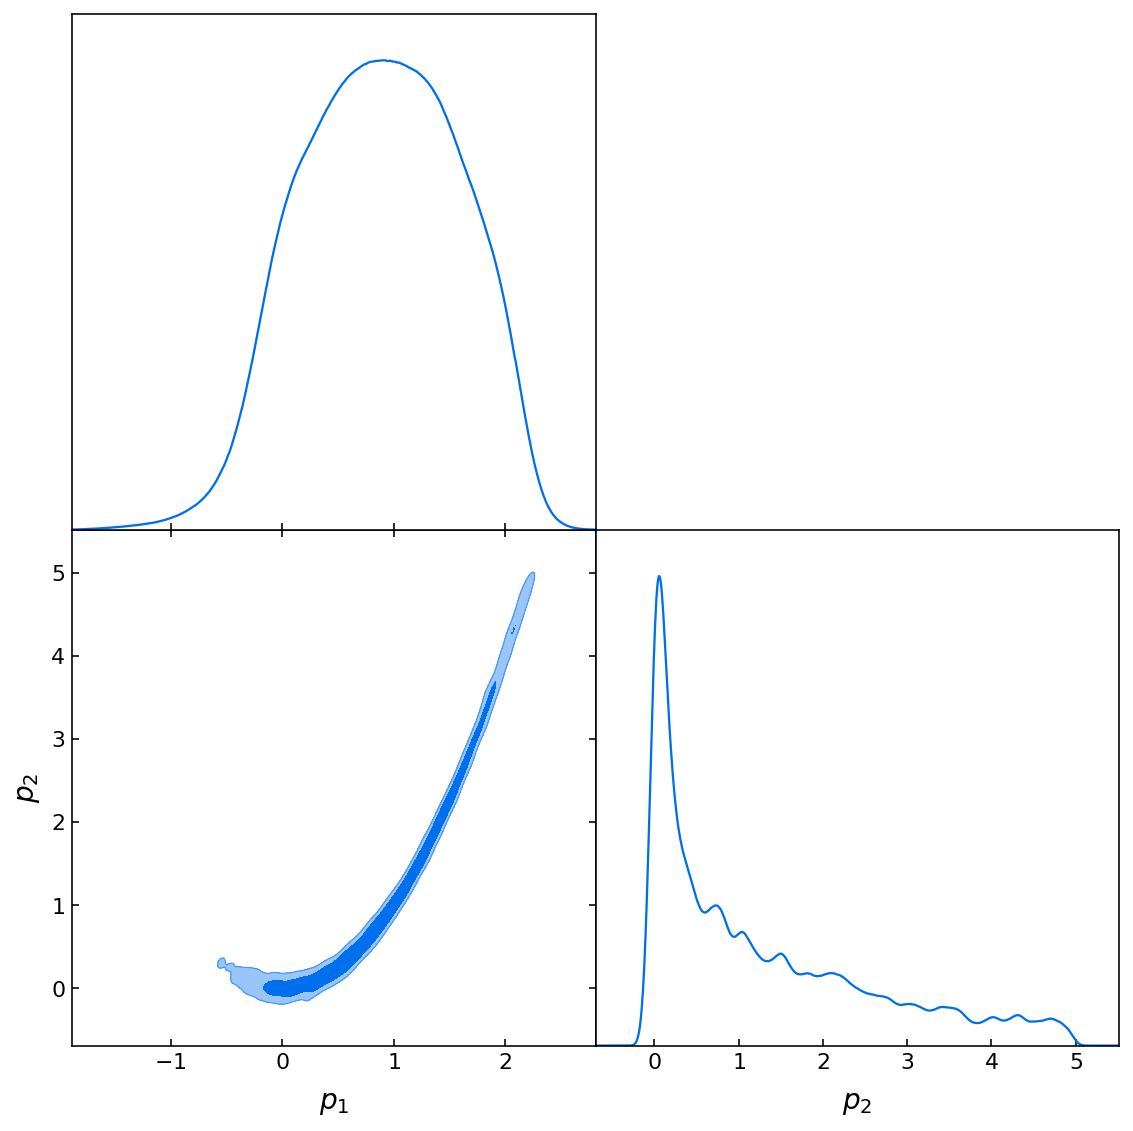

In [19]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

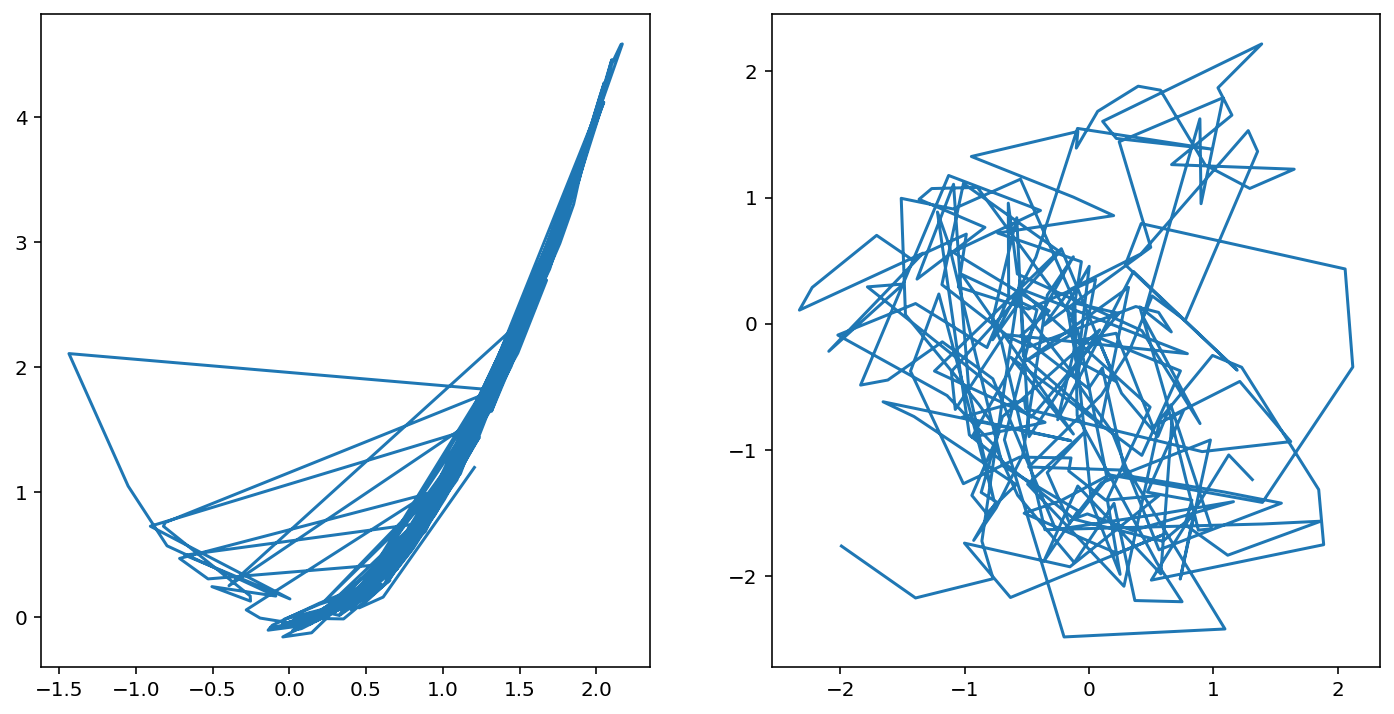

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(samples[0][500:1000,0], samples[0][500:1000,1])
ax[1].plot(latent_samples[0][500:1000,0], latent_samples[0][500:1000,1])
plt.show()

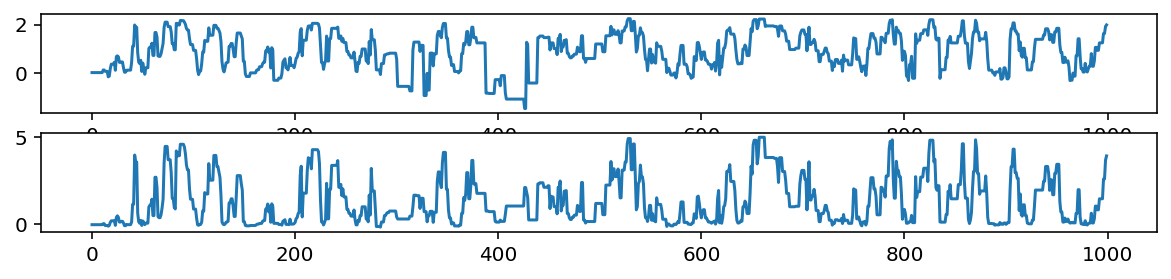

In [21]:
fig, ax = plt.subplots(like.x_dim, 1, figsize=(10, like.x_dim))
for i in range(like.x_dim):
    ax[i].plot(samples[0][500:1500,i])
plt.show()